In [1]:
from numpy import *
import matplotlib.pyplot as plt

In [2]:
def loadSimpleData():
    dataMat = matrix([
    [1., 2.1], 
    [2., 1.1], 
    [1.3, 1.], 
    [1., 1.], 
    [2., 1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return dataMat, classLabels

In [3]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = ones((shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

In [4]:
def buildStump(dataArr, classLabels, D):
    dataMatrix = mat(dataArr);labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
    minError = inf
    for i in range(n):        
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr                
                if weightedError < minError:                    
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

In [5]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):        
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)        
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)      
        expon = multiply(-1*alpha*mat(classLabels).T,classEst)
        D = multiply(D,exp(expon))
        D = D/D.sum()
        aggClassEst += alpha*classEst   
        aggErrors = multiply(sign(aggClassEst)!=mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m        
        if errorRate < 1e-16: 
            break
    return weakClassArr

In [6]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = mat(datToClass)
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],classifierArr[i]['thresh'],classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst    
    return sign(aggClassEst)

In [7]:
def getDecisionBoundary(classifierArr, xrange, yrange, step=0.03):
    x_min = xrange[0]
    x_max = xrange[1]
    y_min = yrange[0]
    y_max = yrange[1]
    
    retX1 = []
    retY1 = []
    
    for i in range(0,int((x_max-x_min)/step) + 1):
        x = x_min + step*i
        sign = 0
        for j in range(0, int((y_max-y_min)/step)+1):
            y = y_min + step*j
            new_sign = adaClassify([x,y], classifierArr)
            if sign == 0:
                sign = new_sign
            elif sign != new_sign:
                retX1.append(x)
                retY1.append(y)
                break
    
    retX2 = []
    retY2 = []
    for i in range(0, int((y_max-y_min)/step)+2):
        y = y_min + step*i
        sign = 0
        for j in range(0,int((x_max-x_min)/step) + 2):
            x = x_min + step*j
            new_sign = adaClassify([x,y], classifierArr)
            if sign == 0:
                sign = new_sign
            elif sign != new_sign:
                retX2.append(x)
                retY2.append(y)
                break
                
    return retX1, retY1, retX2, retY2

In [8]:
dataMat,classLabels = loadSimpleData()
classifierArray = adaBoostTrainDS(dataMat,classLabels,9)

In [9]:
testPoint = [.92,4]
print("point ", testPoint, "classified as %d" % (adaClassify(testPoint,classifierArray)))

point  [0.92, 4] classified as 1


In [10]:
X1_db,Y1_db,X2_db,Y2_db = getDecisionBoundary(classifierArray,[0,2.5],[0,2.5])

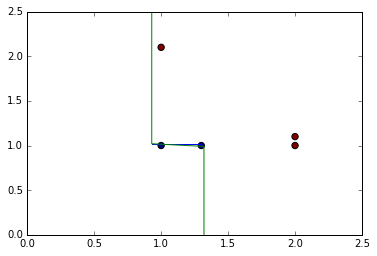

In [11]:
fig=plt.figure()
plt.scatter(dataMat[:,0],dataMat[:,1],s=40,c=classLabels)
plt.plot(X1_db,Y1_db)
plt.plot(X2_db,Y2_db)
plt.xlim(0,2.5)
plt.ylim(0,2.5)
plt.show()